In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from EKF import ExtendedKalmanFilter

# Symbols definition

In [2]:
#States
Tz, Tw, Tt, beta, Uwall = sp.symbols('Tz Tw Tt beta Uwall')

#Inputs
Cf, Tz_ref, Te = sp.symbols('Cf Tz_ref Te')

#Parameters
Cz, Uwin, alpha, Cwall, mw, cw, Pmax, sigma, COP, T_shift, Np = sp.symbols('Cz Uwin alpha Cwall mw cw Pmax sigma COP T_shift Np')

# Equations definition

In [3]:
# Define the state equations, output equations, state symbols, input symbols, and parameters

beta_nl = beta/(1+sp.exp(-sigma*(Tz_ref-Tz-T_shift)))

state_equations = [Tz +1/Cz*(Uwall*(Tw-Tz)+Uwin*(Te-Tz)+alpha*Np+beta_nl*(Tt-Tz)),
                    Tw+1/Cwall*(Uwall*(Te-Tw)+Uwall*(Tz-Tw)),
                    Tt+1/(mw*cw)*(Pmax*COP*Cf + beta_nl*(Tz-Tt)),
                    beta,
                    Uwall
                    ]

output_equation = [Tz,
                   Tt
                   ]

state_symbols = [Tz, Tw, Tt, beta, Uwall]
input_symbols = [Cf, Tz_ref, Te]

params_dict = { "Cz" : 6.2608e8,
                "Uwin" : 1.1362e5,
                "alpha" : 3.4024e3,
                "Cwall" : 8.1597e9,
                "mw" : 9.788e3,
                "cw" : 4186,
                "Pmax" : 8.58e6,
                "sigma" : 2.2,
                "COP" : 5.4,
                "T_shift" : 0,
                "Np" : 0
                }  

Q_k = np.diag([0.01232704273585308, 0.04636850373432094, 0.01227997718764724, 137465487.70116445,893436286806.1382]) # Process noise covariance
R_k = np.diag([0.1, 0.1]) # Measurement noise covariance

P_0 = np.eye(len(state_symbols))  # Initial state covariance estimate

# Create an instance of the ExtendedKalmanFilter class
ekf = ExtendedKalmanFilter(state_equations, output_equation, state_symbols, input_symbols, params_dict, Q_k, R_k, P_0)

# Loading dataframe

In [10]:
df = pd.read_csv('Data_expl_1.csv')

Cf = df['Cf_0']
Tz_ref_anti = df['Tz_ref_anti']
Te = df['Te']
Np = df['Np']
Tz_mean = df['Tz_mean']
Tt_mean = df['Tt_mean']
Twall_mean = df['Twall_mean']
beta_true = df['beta']
Uwall_true = df['Uwall']


# Initial guesses
beta_init = 10000000
Uwall_init = 10000000

# Initial conditions
y_k = np.array([Tz_mean, Tt_mean]).T
u_k = np.array([Cf, Tz_ref_anti, Te]).T
x_k_minus_1 = np.array([Tz_mean[0], Twall_mean[0], Tt_mean[0], beta_init, Uwall_init])

# Loop

In [5]:
# Number of time steps
time_steps = len(df)

x_k_tot = np.empty((time_steps, len(state_symbols)))

# Iterate over time steps
for k in range(time_steps):

    x_k = ekf.ekf(x_k_minus_1, [u_k[k]], y_k[k])

    # print(f"Time step {k}:")
    # print("Updated state vector:")
    # print(x_k)

    x_k_tot[k] = x_k[:]

    x_k_minus_1 = x_k

In [7]:
# fig, ax = plt.subplots()
# #ax.plot(Tz_mean, label='Tz_mean')  
# ax.plot(Twall_mean, label='Twall_mean')
# #ax.plot(Tt_mean, label='Tt_mean')
# ax.set_xlabel('T')
# ax.set_ylabel('Temperature (C)')
# ax.legend()

# plt.show()

In [ ]:
#fig, ax = plt.subplots()
##ax.plot(x_k_tot.T[0], label='Tz_mean')  
#ax.plot(x_k_tot.T[1], label='Twall_mean')
##ax.plot(x_k_tot.T[2], label='Tt_mean')
#ax.set_xlabel('mins')
#ax.set_ylabel('Temperature (C)')
#ax.legend()

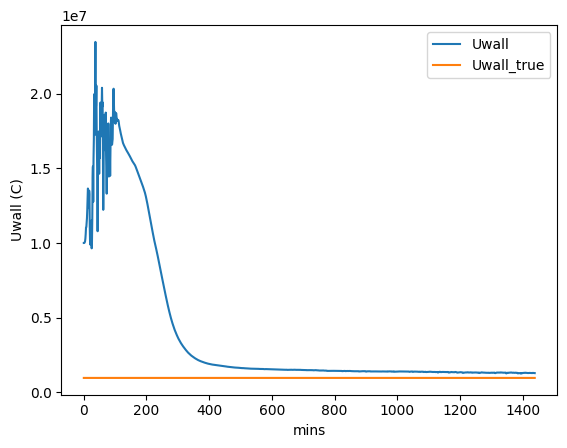

In [11]:
fig, ax = plt.subplots()
ax.plot(x_k_tot.T[4], label='Uwall')
ax.plot(Uwall_true, label='Uwall_true')
ax.set_xlabel('mins')
ax.set_ylabel('Uwall (C)')
ax.legend()

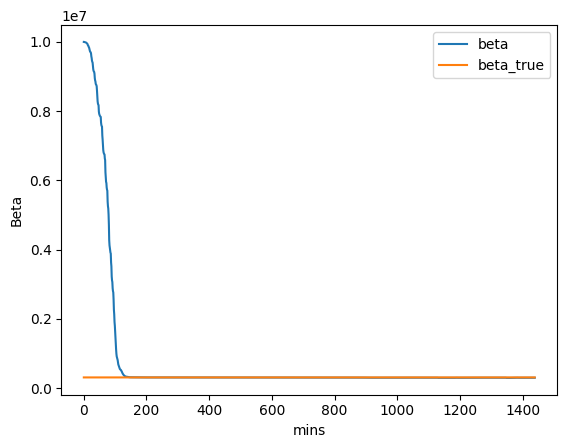

In [12]:
fig, ax = plt.subplots()
ax.plot(x_k_tot.T[3], label='beta')
ax.plot(beta_true, label='beta_true')
ax.set_xlabel('mins')
ax.set_ylabel('Beta')
ax.legend()